# Basic Linear Regression with neon

Tony Reina<br>
28 JUNE 2017

This is a very basic example of doing [linear regression](https://en.wikipedia.org/wiki/Linear_regression) with Intel-Nervana's neon Deep Learning platform. It is based on [this code](http://neon.nervanasys.com/index.html/loading_data.html). 

This code shows that neon is not just for neural networks. It can handle all sorts of numerical computations and optimizations.

Linear regression is a common statistical method for fitting a line to data. It allows us to create a linear model so that we can predict outcomes based on new data.

We'll generate a simple line with some random noise and then use gradient descent to determine the parameters.

This also shows how to load custom data (e.g. user generated numpy arrays) into the neon DataIterator ([ArrayIterator](http://neon.nervanasys.com/index.html/loading_data.html#arrayiterator)).

>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License. You may obtain a copy of the License at

>     http://www.apache.org/licenses/LICENSE-2.0

> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Generate a backend for neon to use

This sets up either our GPU or CPU connection to neon. If we don't start with this, then ArrayIterator won't execute.

We're asking neon to use the cpu, but can change that to a gpu if it is avaliable. Batch size refers to how many data points are taken at a time. For example, here we want to computer the gradient of 5 data points at a time. Here's a primer on [Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

>Technical note:  Your batch size must always be much less than the number of points in your data. So if you have 50 points, then set your batch size to something much less than 50. I'd suggest setting the batch size to no more than 10% of the number of data points.

## Load custom data for neon to use

We can use this to generate datasets that neon understands for any custom data (e.g. python, numpy, etc.). The default behavior is to automatically turn the labels (y) into one-hot encoding for classification problems. We'll override that because we want to do regression (i.e. continuous values)

In [1]:
import numpy as np

m = 123.45   # Slope of our line (weight)
b = -67.89   # Intercept of our line (bias)

numDataPoints = 50  # Let's just have 50 total data points

X = np.random.rand(numDataPoints, 1)  # Let's generate a vector X with 10,000 random numbers

noiseScale = 1.7  # The larger this value, the noisier the data.

trueLine = m*X + b  # Let's generate a vector Y based on a linear model of X 
y = trueLine + noiseScale * np.random.randn(numDataPoints, 1)  # Let's add some noise so the line is more like real data.

In [2]:
from neon.data import ArrayIterator
from neon.backends import gen_backend

gen_backend(backend='cpu', batch_size=numDataPoints//10)  # Change to 'gpu' if you have gpu support 

train = ArrayIterator(X=X, y=y, make_onehot=False)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

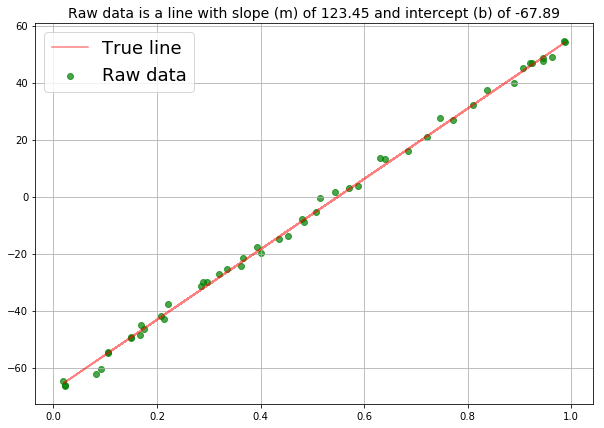

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, alpha=0.7, color='g')
plt.plot(X, trueLine, alpha=0.5, color='r')
plt.title('Raw data is a line with slope (m) of {} and intercept (b) of {}'.format(m, b), fontsize=14);
plt.grid('on');
plt.legend(['True line', 'Raw data'], fontsize=18);

## Let's import the neon libraries we'll need for gradient descent

In [5]:
from neon.initializers import Gaussian
from neon.optimizers import GradientDescentMomentum
from neon.layers import Linear, Bias
from neon.layers import GeneralizedCost
from neon.transforms import SumSquared
from neon.models import Model
from neon.callbacks.callbacks import Callbacks

## Initialize the weights and bias variables

We'll use numbers from the Gaussian distribution ($\mu=0, \sigma=1$) to initialize the weights and bias terms for our regression model.

In [6]:
init_norm = Gaussian(loc=0.0, scale=1)

## Create our single layer linear model

Neon is a pro at handling complicated graphs like deep neural networks. Nevertheless, it can also handle the simplest graph: a single layer linear model.

In [7]:

layers = [Linear(1, init=init_norm), # Linear layer with 1 unit
          Bias(init=init_norm)]      # Bias layer

model = Model(layers=layers)

## Cost function

How "close" is the model's prediction is to the true value? For the case of regression we'll just define the sum of the squared error between the model's prediction and the true value. Other types of models may require different cost functions.

In [8]:
# Loss function is the squared difference
cost = GeneralizedCost(costfunc=SumSquared())

## Gradient descent

All of our models will use [gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). We will iteratively update the model weights and biases in order to minimize the cost of the model.

In [9]:
optimizer = GradientDescentMomentum(0.1, momentum_coef=0.9)

## Run the model

This starts gradient descent. The number of epochs is how many times we want to perform gradient descent on our entire training dataset. So 11 epochs means that we repeat gradient descent on our data 10 times in a row.

In [10]:
# Execute the model
model.fit(train, 
          optimizer=optimizer, 
          num_epochs=11, 
          cost=cost,
          callbacks=Callbacks(model))

Epoch 0   [Train |████████████████████|   10/10   batches, 637.42 cost, 0.01s]
Epoch 1   [Train |████████████████████|   10/10   batches, 235.13 cost, 0.01s]
Epoch 2   [Train |████████████████████|   10/10   batches, 21.35 cost, 0.01s] 
Epoch 3   [Train |████████████████████|   10/10   batches, 4.23 cost, 0.01s] 
Epoch 4   [Train |████████████████████|   10/10   batches, 9.19 cost, 0.01s]
Epoch 5   [Train |████████████████████|   10/10   batches, 5.32 cost, 0.01s]
Epoch 6   [Train |████████████████████|   10/10   batches, 2.18 cost, 0.01s]
Epoch 7   [Train |████████████████████|   10/10   batches, 1.53 cost, 0.01s]
Epoch 8   [Train |████████████████████|   10/10   batches, 1.49 cost, 0.01s]
Epoch 9   [Train |████████████████████|   10/10   batches, 1.46 cost, 0.01s]
Epoch 10  [Train |████████████████████|   10/10   batches, 1.41 cost, 0.01s]


## Print the results

How close are we to the true line?

Play around with the noiseScale, m, and b parameters to convince yourself that neon is properly fitting the model.

In [11]:
# print weights
slope = model.get_description(True)['model']['config']['layers'][0]['params']['W'][0][0]
print ("calculated slope = {:.3f}, true slope = {:.3f}".format(slope, m))

bias_weight = model.get_description(True)['model']['config']['layers'][1]['params']['W'][0][0]
print ("calculated bias = {:.3f}, true bias = {:.3f}".format(bias_weight, b))

calculated slope = 123.976, true slope = 123.450
calculated bias = -67.891, true bias = -67.890


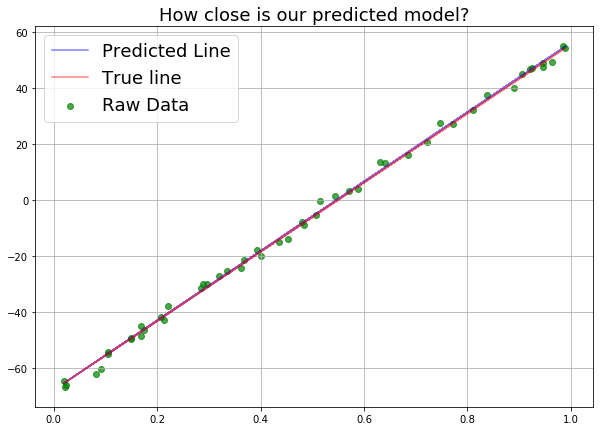

In [12]:
plt.figure(figsize=(10,7))
plt.plot(X, slope*X+bias_weight, alpha=0.5, color='b')
plt.scatter(X, y, alpha=0.7, color='g')
plt.plot(X, trueLine, alpha=0.5, color='r')

plt.title('How close is our predicted model?', fontsize=18);
plt.grid('on');
plt.legend(['Predicted Line', 'True line', 'Raw Data'], fontsize=18);

## Despite the data having some noise, linear regression with neon is still able to approximate the true linear model.